In [43]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from windrose import WindroseAxes
from matplotlib.dates import date2num
from utide import solve, reconstruct
import numpy as np
import pandas as pd
from windrose import WindroseAxes
import scipy as sp
import hvplot.xarray
from eofs.xarray import Eof
import glob
from statsmodels.tsa.stattools import acf
from hampel import hampel # for outlier removal
#import sktime as sk

## GOM background

In [3]:
GOMECC=pd.read_excel('Temp_data/GOMECC_USF_DIC_UW.xls').rename(columns={'GMT':'time'}).set_index('time').to_xarray()

DICts=GOMECC.DIC.where(GOMECC.DIC>0,np.nan).interpolate_na(dim='time')


In [4]:
DICts

<xarray.DataArray 'DIC' (time: 2879)>
array([1998.48682634, 2001.48913306, 1993.58459952, ..., 1992.46619235,
       1988.93384105, 1989.77586562])
Coordinates:
  * time     (time) datetime64[ns] 2007-07-11T03:38:30 ... 2007-08-02T20:00:49

In [5]:
DICts=GOMECC.DIC.where(GOMECC.DIC>0,np.nan).interpolate_na(dim='time')
DICts_nrm=(DICts-DICts.mean(dim='time'))/DICts.std(dim='time')

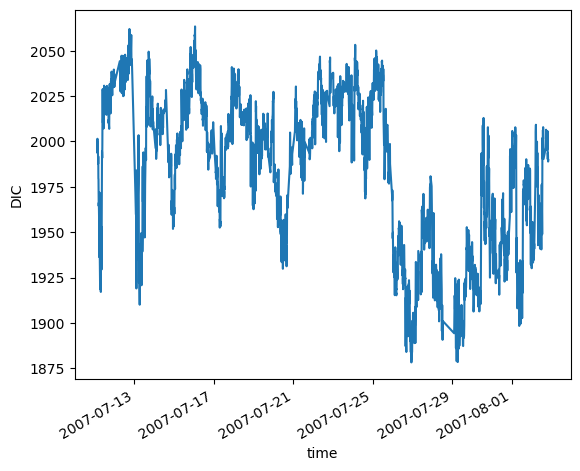

In [19]:
DICts.plot()

In [ ]:
DICts.mean(dim='time')

<xarray.DataArray 'DIC' ()>
array(1984.81630719)

In [ ]:
DICts.var(dim='time')

<xarray.DataArray 'DIC' ()>
array(1750.45051547)

## Power single source

In [61]:
def read_one(filenm='Temp_data/statistics_24.nc',verbose=False):
    if verbose:
        print('Open: '+ filenm)
    stats=xr.open_dataset('Temp_data/statistics_24.nc')

    indx=stats['mean'].argmax(dim=['x','y'])
    
    #mxs=inarr.isel(x=indx['x'],y=indx['y'])
    stats['xs']=stats.x-stats.x.isel(x=indx['x'])   
    stats['ys']=stats.y-stats.y.isel(y=indx['y'])
    stats['r']=np.sqrt(stats.xs**2+stats.ys**2)
    stats= stats.assign_coords(r=stats.r)
    stats= stats.assign_coords(xs=stats.xs)
    stats= stats.assign_coords(ys=stats.ys)
    #stats=stats.stack(z=['x','y'])
    return stats

In [62]:
files=glob.glob('Temp_data/statistics_*[0-99].nc')
all_stat=[]
for file in files:
    all_stat.append(read_one(file))

all_stat=xr.concat(all_stat,dim='source')

In [63]:
stata=all_stat.stack(z=['source','x','y']).groupby_bins('r', np.r_[0:3000:10]).mean(skipna=True)
stata

<xarray.Dataset>
Dimensions:         (r_bins: 299, dt: 3)
Coordinates:
  * r_bins          (r_bins) object (0, 10] (10, 20] ... (2980, 2990]
  * dt              (dt) float64 900.0 1.8e+03 3.6e+03
Data variables:
    mean            (r_bins) float64 0.2819 0.2567 0.2087 ... 0.0005322 0.00043
    var             (r_bins) float64 0.208 0.1577 0.103 ... 4.779e-06 3.15e-06
    max             (r_bins) float64 2.244 1.866 1.465 ... 0.007617 0.004853
    delta_mean      (r_bins, dt) float64 0.0002924 0.0005848 ... 8.922e-07
    delta_mean_abs  (r_bins, dt) float64 0.01604 0.03146 ... 5.764e-05 0.0001141
    delta_var       (r_bins, dt) float64 0.002249 0.008637 ... 2.625e-07
    delta_max       (r_bins, dt) float64 0.3591 0.6215 ... 0.000638 0.001227
    delta_min       (r_bins, dt) float64 -0.2856 -0.5037 ... -0.0006768 -0.0013

In [11]:
stata['mean']

<xarray.DataArray 'mean' (r_bins: 299)>
array([2.81905300e-01, 2.56714192e-01, 2.08739626e-01, 1.20467568e-01,
       5.97331310e-02, 7.28781330e-02, 6.64257235e-02, 5.18556970e-02,
       3.01238466e-02, 3.97500606e-02, 3.59793864e-02, 3.95454737e-02,
       1.71497158e-02, 2.26443520e-02, 2.56475900e-02, 2.85462377e-02,
       1.40997606e-02, 1.46651204e-02, 1.70071016e-02, 1.84919252e-02,
       1.94653891e-02, 1.02821777e-02, 1.23158100e-02, 1.47059351e-02,
       1.43697374e-02, 1.10755151e-02, 8.74192305e-03, 1.10436976e-02,
       1.16983521e-02, 1.25622078e-02, 7.37015578e-03, 7.26777190e-03,
       9.27266405e-03, 9.24042435e-03, 1.05067572e-02, 7.23684404e-03,
       7.37338353e-03, 7.02572546e-03, 6.43737278e-03, 8.33530724e-03,
       8.95273212e-03, 5.10273302e-03, 6.16845645e-03, 5.46845278e-03,
       6.46999343e-03, 7.66258554e-03, 3.53835712e-03, 5.87715862e-03,
       5.52937831e-03, 4.42573194e-03, 7.79716791e-03, 6.43544140e-03,
       2.98251567e-03, 5.53594309e-03, 4.92351626e-03, 3.88698402e-03,
       5.88700680e-03, 6.40153240e-03, 2.27845382e-03, 4.74911975e-03,
       4.96334213e-03, 3.53939961e-03, 5.25112612e-03, 4.94427383e-03,
       3.23605901e-03, 2.74742639e-03, 4.47143503e-03, 4.43851302e-03,
       3.48112156e-03, 3.29933883e-03, 5.52502448e-03, 2.82339596e-03,
       3.02009996e-03, 3.54643629e-03, 4.23398778e-03, 3.45099281e-03,
       3.03238130e-03, 3.37829976e-03, 2.80732123e-03, 3.46799303e-03,
...
       1.11885633e-03, 5.15168870e-04, 7.04651247e-04, 1.18182958e-03,
       2.21141308e-03, 1.23228170e-03, 1.26129445e-03, 9.29799578e-04,
       8.85315610e-04, 7.21735735e-04, 9.40844971e-04, 8.35454246e-04,
       8.12459966e-04, 1.57513378e-03, 1.25638593e-03, 1.02985316e-03,
       6.05450220e-04, 6.99170569e-04, 8.51435205e-04, 8.89024220e-04,
       8.31652017e-04, 7.22023482e-04, 5.97345110e-04, 8.27554307e-04,
       1.02467756e-03, 1.97276466e-03, 1.28976140e-03, 9.59865665e-04,
       3.28745504e-04, 4.85155124e-04, 6.14857789e-04, 3.45484467e-04,
       8.07857376e-04, 7.22803962e-04, 7.89172125e-04, 1.20495772e-03,
       2.17713845e-03, 1.16922379e-03, 6.93083513e-04, 7.78498189e-04,
       7.19638598e-04, 5.58048140e-04, 1.90321012e-04, 5.35055930e-04,
       3.52106800e-04, 3.45705302e-04, 1.04777142e-03, 1.74432846e-03,
       1.78351780e-03, 6.97186943e-04, 5.74161602e-04, 6.36608462e-04,
       8.76174187e-04, 5.74567413e-04, 4.20185562e-04, 4.54485639e-04,
       5.75435676e-04, 2.21781695e-04, 7.56365688e-04, 1.42500555e-03,
       1.44281450e-03, 8.47439017e-04, 7.90857023e-04, 6.51458899e-04,
       3.27708098e-04, 3.20564146e-04, 7.28793104e-04, 8.79949858e-04,
       2.87629585e-04, 4.01773172e-04, 3.56916338e-04, 1.04711235e-03,
       1.02616173e-03, 7.46587169e-04, 4.52020239e-04, 6.25129019e-04,
       5.87121837e-04, 5.32156271e-04, 4.30046039e-04])
Coordinates:
  * r_bins   (r_bins) object (0, 10] (10, 20] ... (2970, 2980] (2980, 2990]

In [94]:
stata=stata.assign_coords(r=('r_bins',np.asarray([v.mid for v in stata['r_bins'].values] )))
stata

<xarray.Dataset>
Dimensions:         (r_bins: 299, dt: 3)
Coordinates:
  * r_bins          (r_bins) object (0, 10] (10, 20] ... (2980, 2990]
  * dt              (dt) float64 900.0 1.8e+03 3.6e+03
    r               (r_bins) float64 5.0 15.0 25.0 ... 2.975e+03 2.985e+03
Data variables:
    mean            (r_bins) float64 0.2819 0.2567 0.2087 ... 0.0005322 0.00043
    var             (r_bins) float64 0.208 0.1577 0.103 ... 4.779e-06 3.15e-06
    max             (r_bins) float64 2.244 1.866 1.465 ... 0.007617 0.004853
    delta_mean      (r_bins, dt) float64 0.0002924 0.0005848 ... 8.922e-07
    delta_mean_abs  (r_bins, dt) float64 0.01604 0.03146 ... 5.764e-05 0.0001141
    delta_var       (r_bins, dt) float64 0.002249 0.008637 ... 2.625e-07
    delta_max       (r_bins, dt) float64 0.3591 0.6215 ... 0.000638 0.001227
    delta_min       (r_bins, dt) float64 -0.2856 -0.5037 ... -0.0006768 -0.0013

In [101]:
Z_alpha=1.96
Z_beta=0.84
sigma=41
N_center=1

scaling=((Z_alpha+Z_beta)*sigma/np.sqrt(N_center))/stata['mean'].max(dim='r_bins')
scaling

<xarray.DataArray 'mean' ()>
array(407.22895171)

(0.0, 500.0)

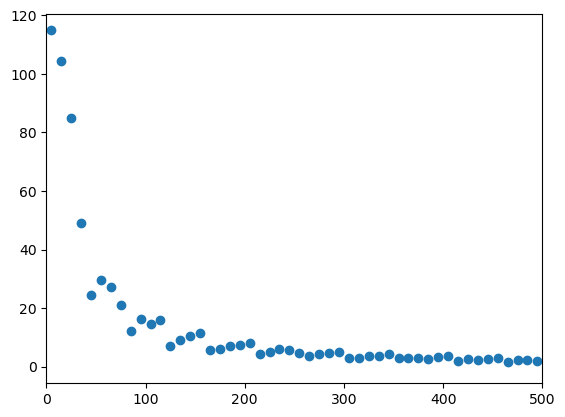

In [103]:
plt.scatter(x=stata.r,y=scaling*stata['mean'])
plt.xlim(0,500)

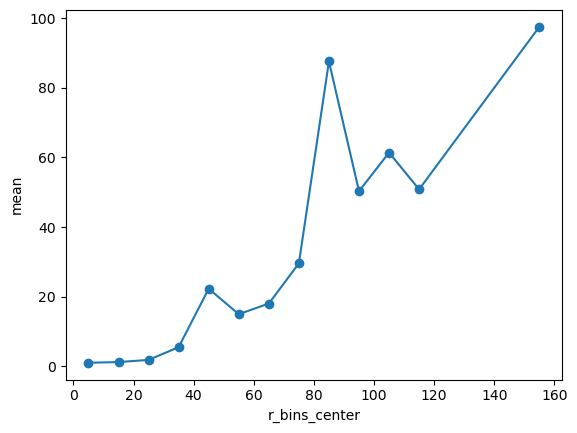

In [110]:
N_meas=(Z_alpha+Z_beta)**2/(scaling*stata['mean']/sigma)**2
N_meas.where(N_meas<100,drop=True).plot(marker='o')

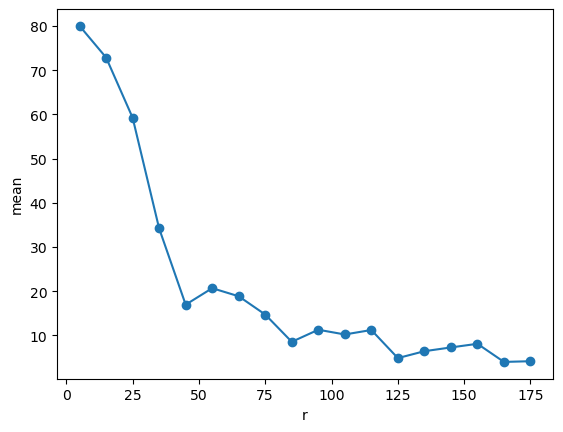

In [97]:
pltfld=scaling*stata.where(stata['r']<180,drop=True)['mean']
pltfld.plot(x='r',marker='o')

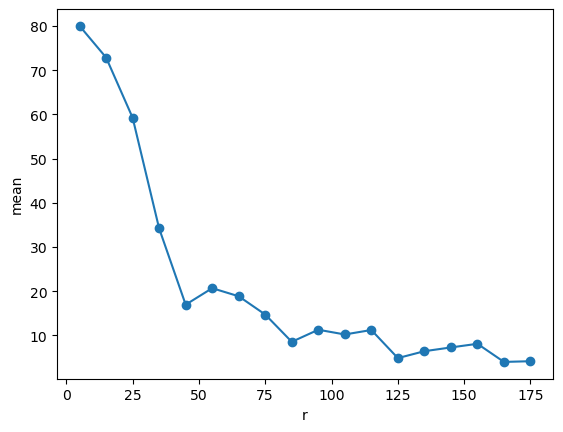

In [98]:
y=pltfld.where(pltfld < 200,drop=True)
y.plot(x='r',marker='o')


In [99]:
(1.96+0.84)

2.8

In [91]:
x=y.r.values
num=(1.96+0.84)**2/(y/41)**2

num=hampel(pd.Series(num.values), window_size=3, n=1, imputation=True)
num.plot(marker='o')
#plt.scatter(x=x,y=num)

AttributeError: 'Series' object has no attribute 'r'

In [92]:
num

0       0.915211
1       1.103641
2       1.669237
3       5.011728
4       9.352911
5      13.694094
6      16.483718
7      27.047979
8      36.539583
9      46.031187
10     56.184984
11     46.508700
12     83.377153
13    141.843021
14    110.569321
15     89.254478
16    194.568606
17    194.568606
dtype: float64

In [80]:
A = np.vstack([x, np.ones(len(x))]).T

# turn y into a column vector
y = num#[:, np.newaxis]
alpha = np.dot((np.dot(np.linalg.inv(np.dot(A.T,A)),A.T)),y.T)
print(alpha)
yn=alpha[0]*x + alpha[1]

[  1.07544311 -37.08298261]


In [86]:
alpha[1]/alpha[0]

-34.48158450188589

In [87]:
y

0       0.915211
1       1.103641
2       1.669237
3       5.011728
4       9.352911
5      13.694094
6      16.483718
7      27.047979
8      36.539583
9      46.031187
10     56.184984
11     46.508700
12     83.377153
13    141.843021
14    110.569321
15     89.254478
16    194.568606
17    194.568606
dtype: float64

In [85]:
x

array([  5.,  15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,  95., 105.,
       115., 125., 135., 145., 155., 165., 175.])

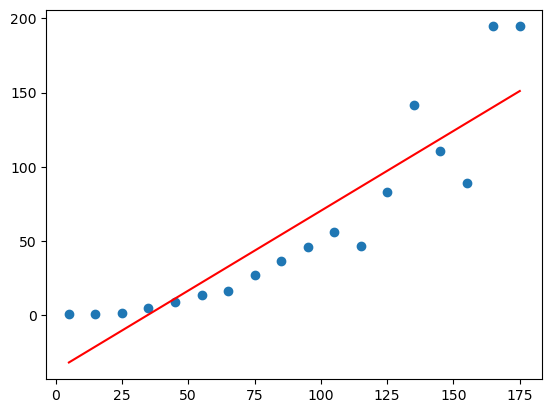

In [81]:
plt.plot(x,yn,'r')
plt.scatter(x,y)

## BAyes


In [111]:
DICts

<xarray.DataArray 'DIC' (time: 2879)>
array([1998.48682634, 2001.48913306, 1993.58459952, ..., 1992.46619235,
       1988.93384105, 1989.77586562])
Coordinates:
  * time     (time) datetime64[ns] 2007-07-11T03:38:30 ... 2007-08-02T20:00:49

In [113]:
sigma=DICts.std(dim='time')
sigma

<xarray.DataArray 'DIC' ()>
array(41.83838567)

In [157]:
p0=0.01
q=0.95
alpha=p0*(1-q)/q/(1-p0)
np.log(alpha)

-7.539558829301029

In [158]:
stata

<xarray.Dataset>
Dimensions:         (r_bins: 299, dt: 3)
Coordinates:
  * r_bins          (r_bins) object (0, 10] (10, 20] ... (2980, 2990]
  * dt              (dt) float64 900.0 1.8e+03 3.6e+03
    r               (r_bins) float64 5.0 15.0 25.0 ... 2.975e+03 2.985e+03
Data variables:
    mean            (r_bins) float64 0.2819 0.2567 0.2087 ... 0.0005322 0.00043
    var             (r_bins) float64 0.208 0.1577 0.103 ... 4.779e-06 3.15e-06
    max             (r_bins) float64 2.244 1.866 1.465 ... 0.007617 0.004853
    delta_mean      (r_bins, dt) float64 0.0002924 0.0005848 ... 8.922e-07
    delta_mean_abs  (r_bins, dt) float64 0.01604 0.03146 ... 5.764e-05 0.0001141
    delta_var       (r_bins, dt) float64 0.002249 0.008637 ... 2.625e-07
    delta_max       (r_bins, dt) float64 0.3591 0.6215 ... 0.000638 0.001227
    delta_min       (r_bins, dt) float64 -0.2856 -0.5037 ... -0.0006768 -0.0013

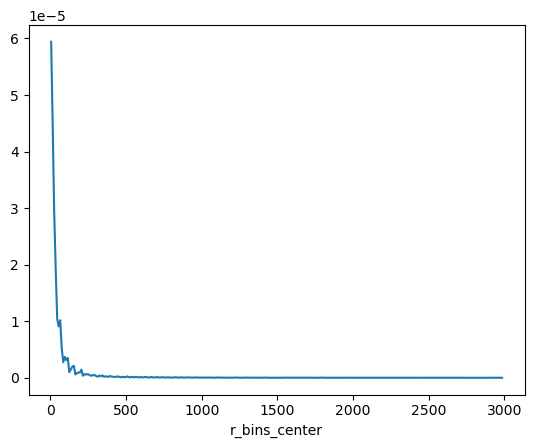

In [160]:
np.log(np.sqrt(1+stata['var']/sigma**2)).plot()

In [180]:
scale=400/stata['mean'].max()

In [181]:
Delta=scale*stata['mean']
sigma_D=scale*np.sqrt(stata['mean'])

In [182]:
sigma_D

<xarray.DataArray 'mean' (r_bins: 299)>
array([753.37008384, 718.92185976, 648.27489036, 492.48365398,
       346.78826211, 383.04991357, 365.69994598, 323.11341358,
       246.27025673, 282.89524465, 269.14333285, 282.1662983 ,
       185.816901  , 213.51908434, 227.2375147 , 239.73485924,
       168.48553397, 171.83022809, 185.04267697, 192.95134665,
       197.9649452 , 143.87962647, 157.46652343, 172.06917351,
       170.09093353, 149.32712957, 132.66618457, 149.11248344,
       153.46844558, 159.03390998, 121.81340509, 120.96434938,
       136.63407225, 136.39633709, 145.44242183, 120.70669429,
       121.84007619, 118.93299   , 113.84424446, 129.54407545,
       134.25625992, 101.35803271, 111.44100016, 104.92741718,
       114.13232636, 124.20652669,  84.40294127, 108.77784627,
       105.51031072,  94.3950677 , 125.29253409, 113.82716511,
        77.49043813, 105.57292595,  99.56218927,  88.46329819,
       108.86894596, 113.52688547,  67.72934333,  97.78298929,
        99.96405295,  84.41537401, 102.82127246,  99.7718459 ,
        80.71699143,  74.3737676 ,  94.88120945,  94.53127133,
        83.71751796,  81.50236453, 105.46876312,  75.39501714,
        77.97715907,  84.49924538,  92.32760069,  83.35444739,
        78.13554659,  82.47186974,  75.18008367,  83.55950483,
...
        47.46176792,  32.20561195,  37.66551085,  48.77914419,
        66.72547687,  49.80945039,  50.39239414,  43.26646585,
        42.21879277,  38.11938227,  43.52269538,  41.0126739 ,
        40.44433834,  56.31388273,  50.29424367,  45.53490156,
        34.91370759,  37.5187464 ,  41.40307062,  42.30712814,
        40.91924126,  38.12698035,  34.67922679,  40.81830828,
        45.42033807,  63.02232042,  50.95788999,  43.96043468,
        25.72685274,  31.25338494,  35.18390904,  26.37369703,
        40.32961694,  38.1475817 ,  39.86048861,  49.25413022,
        66.20636954,  48.51829953,  37.3550682 ,  39.59000467,
        38.06396051,  33.51911797,  19.57492555,  32.82134244,
        26.62526602,  26.38212477,  45.92932083,  59.2612602 ,
        59.92326578,  37.46548614,  33.99960114,  35.80081827,
        42.0002598 ,  34.01161427,  29.08555214,  30.24940467,
        34.03730307,  21.13097805,  39.02318019,  53.56301656,
        53.89667821,  41.30579424,  39.90301739,  36.21598154,
        25.68622817,  25.40470888,  38.30530078,  42.09065775,
        24.06431626,  28.44115418,  26.80649075,  45.91487344,
        45.45322015,  38.77010797,  30.16724775,  35.47656636,
        34.381187  ,  32.73228633,  29.42484783])
Coordinates:
  * r_bins   (r_bins) object (0, 10] (10, 20] ... (2970, 2980] (2980, 2990]
    r        (r_bins) float64 5.0 15.0 25.0 ... 2.965e+03 2.975e+03 2.985e+03

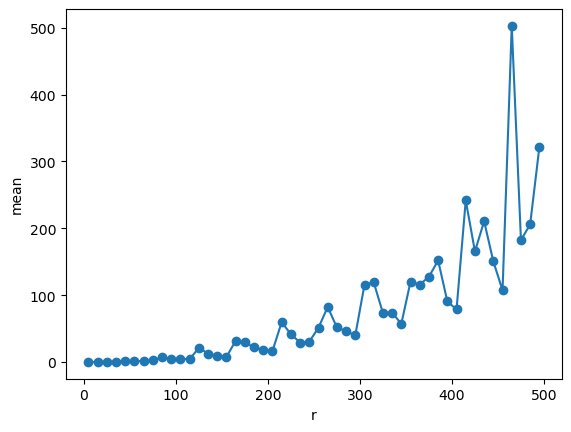

In [202]:
N_res=(np.log(alpha)/(0*np.log(np.sqrt(1+sigma_D**2/41**2))-(Delta/41)**2))
N_res.where(N_res.r<500).plot(x='r',marker='o')

In [184]:
np.log(np.sqrt(1+sigma_D**2/41**2)).min()

<xarray.DataArray 'mean' ()>
array(0.10267154)

In [185]:
A=np.log(np.sqrt(1+sigma_D**2/41**2))
B=(Delta/41)**2

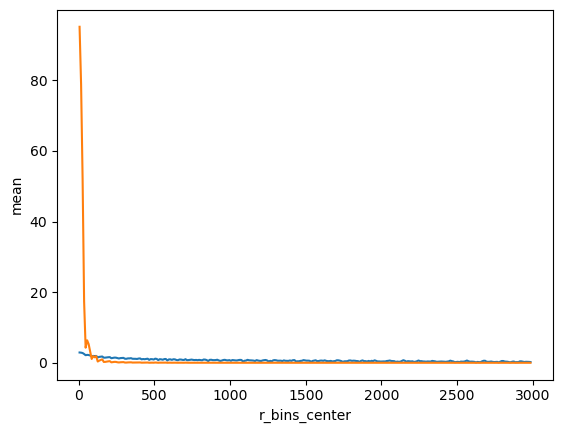

In [198]:
A.plot()
B.plot()

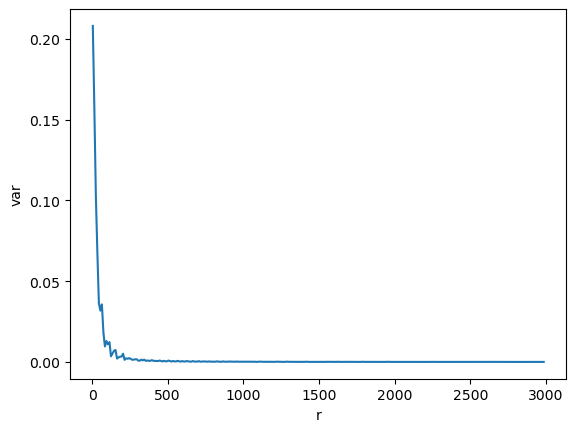

In [191]:
stata['var'].plot(x='r')

In [192]:
GOMECC

<xarray.Dataset>
Dimensions:        (time: 2879)
Coordinates:
  * time           (time) datetime64[ns] 2007-07-11T03:38:30 ... 2007-08-02T2...
Data variables:
    Latitude       (time) object '2859.8631N' '2859.8617N' ... '3738.2554N'
    Longitude      (time) object '09459.9804W' '09459.9787W' ... '06825.0758W'
    TSG-Unit-Temp  (time) float64 29.11 29.1 29.09 29.09 ... 29.46 29.53 29.41
    MicroSal       (time) float64 30.16 30.15 30.15 30.11 ... 36.07 36.08 36.08
    DIC            (time) float64 1.998e+03 2.001e+03 ... 1.989e+03 1.99e+03
    fCO2           (time) float64 -999.0 -999.0 -999.0 ... -999.0 402.9 401.1

## STEMM

In [203]:
stemm=xr.open_dataset('../../STEMM_CCS/Data/pos534.nc')

In [214]:
quarter=stemm.resample(Time='0.25H').interpolate()

/Users/guttorm/opt/anaconda3/envs/ocean/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/guttorm/opt/anaconda3/envs/ocean/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")


In [218]:
quarter.pCO2.mean(dim='Time')

<xarray.DataArray 'pCO2' ()>
array(442.6532925)

In [222]:
quarter.pCO2.diff(dim='Time').std()

<xarray.DataArray 'pCO2' ()>
array(0.25676337)

In [225]:
stata['delta_mean'].max()

<xarray.DataArray 'delta_mean' ()>
array(0.00116967)